# Weather Data 
From ALLL Available sources PPG, NOAA Tula, ASCC station, and my stations

In [ ]:
Introduction: 
    - data gaps are a prevalent issue in weather and environmental modeling 
    - currrent methods for filling data gaps include   (need to learn and apply these methods) 
    - issues with these current methods
    - why machiene learning is cool and useful for this (review of current literature) 
    - what We did
    
Methods: 
    - Data collection instruments, and locations, data procuremtns
    - Maybe should try and do the RNN for filling in PPG data gaps, then the other network for comparitive filling

Notes: 
    for now use daily values. can sub to hourly later maybe if need
    
    # Old method for ppg data based on static datasets,, us the API instead  (Eventiually) 
(note no other NOAA stations are worth their salt) 
    

In [62]:
pd.set_option('display.max_rows', 50)    

In [82]:
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container { width: 95%;} div#menubar-container { width: 85%; } div#maintoolbar-container { width: 99%; } </style> """))

#%matplotlib inline
%matplotlib notebook

import matplotlib 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import seaborn as sns
import os
import io
import datetime
from dateutil import parser, rrule
from datetime import datetime, time, date
import time
import keras 
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
import requests
import scipy
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import re

# import function from current working directory
from getRainfallData import getRainfallData

workspace = os.path.join('.', 'workspace')
#make sure workspace directory exists
if not os.path.exists(workspace):
    os.makedirs(workspace)


pd.set_option('display.max_rows', 50)    
np.set_printoptions(suppress=True)

# Firstly, fill in PPG Airport Data completely
using static data files for now, can switch to an API later when desired to keep all data up to date, will take more work to program
from http://scacis.rcc-acis.org/ for daily data  and also from: https://www.ncdc.noaa.gov/cdo-web/datasets/LCD/stations/WBAN:61705/detail for hourly data


C:\Users\cshuler\Anaconda3\envs\tensorflow_env\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<IPython.core.display.Javascript object>


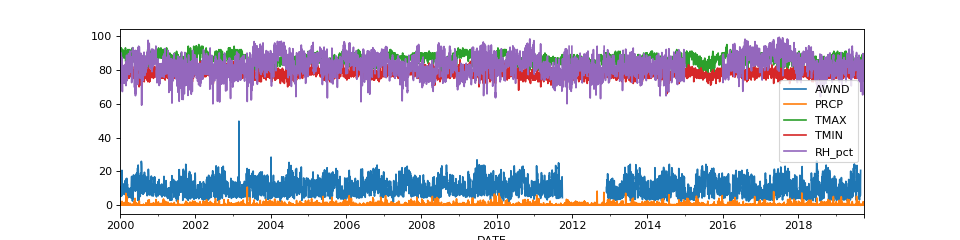

In [83]:
path_PPG_data = os.path.join("..", "Data", 'External_weather_data', 'PPG', "daily")                # open dataset
PPG = pd.read_csv(os.path.join(path_PPG_data, 'PPG-2000-oct2-19-daily.csv'), usecols = [2, 5, 13, 18, 19]) #  ,21])  will give wind directions
PPG['DATE'] = pd.to_datetime(PPG['DATE'], errors='coerce')
PPG = PPG.set_index('DATE')

# Now Hourly Airport Data  (junkshow) for needed only for RH data, not in the daily file for some reason, 
path_PPG_data_RH = os.path.join("..", "Data", 'External_weather_data', 'PPG', "hourly")                # open dataset

a = pd.read_csv(os.path.join(path_PPG_data_RH, 'PPG_2010-2019(oct)-hourly.csv'), usecols = [1,2,3, 48])  # cut out rando columns
b = pd.read_csv(os.path.join(path_PPG_data_RH, 'PPG-2000-2009-hourly.csv'), usecols = [1,2,3, 48])       # cut out rando columns
c = pd.concat([b, a])                                                                                    # merge em together

c = c[c['REPORT_TYPE'] == 'FM-15']                                       # apparently the hourly data we want is codes as FM-15 Data
c['DATE'] = pd.to_datetime(c['DATE'], errors='coerce')                   # string date to real date
c['DATE'] = c['DATE'].dt.round('H')                                      # timestamps are in rando near hour times, round to the hour
c = c.set_index('DATE')
del c['REPORT_TYPE']
del c['SOURCE']
c = c.apply(pd.to_numeric, errors='coerce')                       # convert all columns of DataFrame to floats, turns any non-numerics to nan

#  resample to daily values 
PPG_RH_dat = c.resample('D').mean()      # resample the rain different than the other columns
PPG_RH_dat.rename(columns={'HourlyRelativeHumidity': 'RH_pct'}, inplace=True)      # rename column

PPG = PPG.join(PPG_RH_dat)                 #merge the datasets together

PPG.plot(figsize =(12,3))

# Define some functions

In [84]:
### This is used to Identify and label places where there are gaps in the data

def find_date_gaps(dataset_raw, Colinterest):

    a = dataset_raw[Colinterest].values  # Extract out relevant column from dataframe as array
    ## Now gap filling time: 
    # First: all of this is to go through each dataset and identify the start and the end of each gap. 

    m = np.concatenate(( [True], np.isnan(a), [True] ))  # Mask
    ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1,2)   # Start-stop limits

    gapstarts_L = []; gapends_L = []
    # this is if the series started late, i.e. the first gap is at the beginning
    if ss[0][0] != 0:     
        gapstart = 0
        gapstarts_L.append(gapstart)
        for m in ss:
            gapstart2 = m[1]
            gapstarts_L.append(gapstart2)
            gapends_L.append(m[0])
        del gapstarts_L[-1]                       # the end number is not the start of a new gap so delete this 

    # this is if the series starst at the beginning of the data period, first gap is in the middle 
    for m in ss:
        gapstarts_L.append(m[1])
        gapends_L.append(m[0])
    del gapstarts_L[-1]
    del gapends_L[0]

    gapstarts_Dates = []; gapends_Dates = []
    for h in gapstarts_L:
        date5 = dataset_raw.index[h]
        gapstarts_Dates.append(date5)   # this is a list of the starting date of all gaps
    for h in gapends_L:
        date5 = dataset_raw.index[h]
        gapends_Dates.append(date5)     # this is a list of all the ending dates of the gaps
           
    # list the 
    for idx, val in enumerate(gapstarts_Dates):
        length = gapends_Dates[idx] -gapstarts_Dates[idx]
        print("gap {} is {} from {} to {}".format(idx, length, gapstarts_Dates[idx], gapends_Dates[idx] ))
    
    return gapstarts_Dates, gapends_Dates

In [85]:
# this is used to ID gaps and Autofill less than one week long ones

def ID_n_Fill_gaps(dataset_raw):
    
    dataset_cleanish = dataset_raw.copy()    # create output dataset to map fixed data into
    
    for col in dataset_raw.columns: 
        print('...................................................................................')
        print("{} gaps are".format(col))
        
        # ID gaps
        gapstarts_Dates, gapends_Dates =  find_date_gaps(dataset_raw, col)
        
        # Now fill gaps of one day by using average of yesterday's and tomorrow's values
        for idx, val in enumerate(gapstarts_Dates):
            strt = gapstarts_Dates[idx]                                             # note this is the first day with missing data, if only one this is the missing day
            ends = gapends_Dates[idx]                                               # this is the day where there is data again after a gap ( I think) 
            
            if ends - strt < pd.Timedelta('7 day'):                                # if the gap is 1 day long
                beforepoint = dataset_raw[col].loc[strt-pd.Timedelta('7 day')]      # This is the day before the one with the issing data 
                afterpoint = dataset_raw[col].loc[ends]                             # this is the day where there is data again after a gap ( I think) 
                avepoint = np.mean((beforepoint,afterpoint))                        # average of the adjacient values
                dataset_raw[col].loc[strt:ends] = avepoint                       # FILL the GAP with the ave value

        dataset_cleanish[col] = dataset_raw[col]
    
    return dataset_cleanish

In [225]:
# this is the creation of the DLNN model as a function
def define_model_dense(hidden_layer_sizes, input_shape, activation='relu', optimizer='sgd'):
    
    model = "reset"; del model   # redefine, then delete model to make sure previous model weights are DESTROIED!
    model = Sequential()
    
    model.add(Dense(hidden_layer_sizes[0], activation=activation, input_shape=(input_shape, )))
    for hl_size in hidden_layer_sizes[1: ]:
        model.add(Dense(hl_size, activation=activation))
    
    model.add(Dense(1, activation='linear'))
    model.summary()

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [86]:
# implement the ID and fill gaps to take out any small gaps cuz they are annoying.
dataset_raw = PPG.copy()
dataset_cleanish = ID_n_Fill_gaps(dataset_raw)

...................................................................................
AWND gaps are
gap 0 is 427 days 00:00:00 from 2011-10-01 00:00:00 to 2012-12-01 00:00:00
gap 1 is 1 days 00:00:00 from 2015-02-10 00:00:00 to 2015-02-11 00:00:00
...................................................................................
PRCP gaps are
gap 0 is 1 days 00:00:00 from 2012-07-31 00:00:00 to 2012-08-01 00:00:00
gap 1 is 1 days 00:00:00 from 2012-10-31 00:00:00 to 2012-11-01 00:00:00
gap 2 is 1 days 00:00:00 from 2019-09-01 00:00:00 to 2019-09-02 00:00:00
...................................................................................
TMAX gaps are
gap 0 is 1 days 00:00:00 from 2019-09-30 00:00:00 to 2019-10-01 00:00:00
...................................................................................
TMIN gaps are
gap 0 is 1 days 00:00:00 from 2019-09-06 00:00:00 to 2019-09-07 00:00:00
...................................................................................
RH_pct gaps

# First order calibration and validation 
### looking at how well the network matches the training data, this is mainly to assess model performance and uncertainty
note: need to manually definine columns to work with, 

In [87]:
# this might be automated further in the future but need to find a period where there are no gaps, for now look manually at the potput of this:

ID_n_Fill_gaps(dataset_cleanish)          # just calling this print off a list of the gaps, doesnt do anything since there are no 1 day gaps left. 

""" looks like data is solid from  "2000-01-01"   to "2011-9-30"  """

unbroken_data = dataset_cleanish.loc[:"2011-9-30"]
#unbroken_data.plot()

# double check All is good
print("There are missing values in our train data = {}".format(unbroken_data.isnull().values.any()))

TRAIN_SPLIT = int(len(unbroken_data)*.80)     # train on say 2/3 of the data validate on the rest

...................................................................................
AWND gaps are
gap 0 is 427 days 00:00:00 from 2011-10-01 00:00:00 to 2012-12-01 00:00:00
...................................................................................
PRCP gaps are
...................................................................................
TMAX gaps are
...................................................................................
TMIN gaps are
...................................................................................
RH_pct gaps are
gap 0 is 365 days 00:00:00 from 2015-01-01 00:00:00 to 2016-01-01 00:00:00
There are missing values in our train data = False


In [228]:
# split data for train and validation
train_data = unbroken_data.iloc[:TRAIN_SPLIT]
val_data = unbroken_data.iloc[TRAIN_SPLIT:]


# determine which column to work with
x_cols = ['AWND', 'PRCP', 'TMIN', 'TMAX']
y_col = 'RH_pct'


# set up the training datasets
X_train = train_data[x_cols].values  
# scale the x component of the training data
X_train_scaler = StandardScaler().fit(X_train)
X_train = X_train_scaler.transform(X_train)

y_train = train_data[y_col].values                 # scale the y data too, and then make the scale unique to use it to unscale the final data later
y_train = y_train.reshape(-1, 1)
y_train_scaler = StandardScaler().fit(y_train)
y_train = y_train_scaler.transform(y_train)


# set up the validation datasets
X_val = val_data[x_cols].values  
# scale the x component of the training data
X_val_scaler = StandardScaler().fit(X_val)
X_val = X_val_scaler.transform(X_val)

y_val = val_data[y_col].values
y_val = y_val.reshape(-1, 1)
y_val_scaler = StandardScaler().fit(y_val)
y_val = y_val_scaler.transform(y_val)

In [229]:
input_shape = len(x_cols)
input_shape

4

In [230]:
#define the DL model and its parameters to use for other models creates object named model in memory

hidden_layer_sizes =  [12, 80, 80]
input_shape = len(x_cols)
activation     = 'relu'
optimizer      = 'sgd'

model = "reset"; del model   # redefine, then delete model to make sure previous model weights are DESTROIED!
model = define_model_dense(hidden_layer_sizes, input_shape, activation, optimizer)

# train the network
# Note using callbacks from ( https://www.machinecurve.com/index.php/2019/05/30/avoid-wasting-resources-with-earlystopping-and-modelcheckpoint-in-keras/ )
checkpoint_path = os.path.join(workspace, 'testmodel_random_callback_save2.h5')

keras_callbacks   = [EarlyStopping(monitor='val_loss', patience=150, mode='min', min_delta=0.001),
                     ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')]

history = model.fit(X_train, y_train, epochs=2000,verbose=1, validation_data =(X_val,  y_val), callbacks=keras_callbacks)

## load the best saved model based on validation loss
model = load_model(checkpoint_path)
scores = model.evaluate(X_train, y_train, verbose=1)
print(f'Score: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_324 (Dense)            (None, 12)                60        
_________________________________________________________________
dense_325 (Dense)            (None, 80)                1040      
_________________________________________________________________
dense_326 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_327 (Dense)            (None, 1)                 81        
Total params: 7,661
Trainable params: 7,661
Non-trainable params: 0
_________________________________________________________________
Train on 3432 samples, validate on 859 samples
Epoch 1/2000
3432/3432 [==============================] - 3s 923us/step - loss: 0.8288 - acc: 0.0000e+00 - val_loss: 0.8326 - val_acc: 0.0000e+00
Epoch 2/2000
3432/3432 [==============================] 

Epoch 51/2000
3432/3432 [==============================] - 0s 62us/step - loss: 0.6033 - acc: 0.0000e+00 - val_loss: 0.7688 - val_acc: 0.0000e+00
Epoch 52/2000
3432/3432 [==============================] - 0s 56us/step - loss: 0.6072 - acc: 0.0000e+00 - val_loss: 0.7373 - val_acc: 0.0000e+00
Epoch 53/2000
3432/3432 [==============================] - 0s 53us/step - loss: 0.6047 - acc: 0.0000e+00 - val_loss: 0.7552 - val_acc: 0.0000e+00
Epoch 54/2000
3432/3432 [==============================] - 0s 53us/step - loss: 0.6053 - acc: 0.0000e+00 - val_loss: 0.7351 - val_acc: 0.0000e+00
Epoch 55/2000
3432/3432 [==============================] - 0s 51us/step - loss: 0.6078 - acc: 0.0000e+00 - val_loss: 0.7550 - val_acc: 0.0000e+00
Epoch 56/2000
3432/3432 [==============================] - 0s 52us/step - loss: 0.6039 - acc: 0.0000e+00 - val_loss: 0.7395 - val_acc: 0.0000e+00
Epoch 57/2000
3432/3432 [==============================] - 0s 51us/step - loss: 0.6022 - acc: 0.0000e+00 - val_loss: 0.8340 

3432/3432 [==============================] - 0s 58us/step - loss: 0.5840 - acc: 0.0000e+00 - val_loss: 0.7380 - val_acc: 0.0000e+00
Epoch 108/2000
3432/3432 [==============================] - 0s 61us/step - loss: 0.5858 - acc: 0.0000e+00 - val_loss: 0.7325 - val_acc: 0.0000e+00
Epoch 109/2000
3432/3432 [==============================] - 0s 54us/step - loss: 0.5877 - acc: 0.0000e+00 - val_loss: 0.8784 - val_acc: 0.0000e+00
Epoch 110/2000
3432/3432 [==============================] - 0s 49us/step - loss: 0.5831 - acc: 0.0000e+00 - val_loss: 0.8646 - val_acc: 0.0000e+00
Epoch 111/2000
3432/3432 [==============================] - 0s 55us/step - loss: 0.5875 - acc: 0.0000e+00 - val_loss: 0.7951 - val_acc: 0.0000e+00
Epoch 112/2000
3432/3432 [==============================] - 0s 57us/step - loss: 0.5856 - acc: 0.0000e+00 - val_loss: 0.7589 - val_acc: 0.0000e+00
Epoch 113/2000
3432/3432 [==============================] - 0s 63us/step - loss: 0.5819 - acc: 0.0000e+00 - val_loss: 0.8201 - val_ac

Epoch 163/2000
3432/3432 [==============================] - 0s 53us/step - loss: 0.5696 - acc: 0.0000e+00 - val_loss: 0.7500 - val_acc: 0.0000e+00
Epoch 164/2000
3432/3432 [==============================] - 0s 64us/step - loss: 0.5724 - acc: 0.0000e+00 - val_loss: 0.7432 - val_acc: 0.0000e+00
Epoch 165/2000
3432/3432 [==============================] - 0s 66us/step - loss: 0.5736 - acc: 0.0000e+00 - val_loss: 0.7758 - val_acc: 0.0000e+00
Epoch 166/2000
3432/3432 [==============================] - 0s 59us/step - loss: 0.5706 - acc: 0.0000e+00 - val_loss: 0.7829 - val_acc: 0.0000e+00
Epoch 167/2000
3432/3432 [==============================] - 0s 60us/step - loss: 0.5733 - acc: 0.0000e+00 - val_loss: 0.7894 - val_acc: 0.0000e+00
Epoch 168/2000
3432/3432 [==============================] - 0s 56us/step - loss: 0.5743 - acc: 0.0000e+00 - val_loss: 0.7586 - val_acc: 0.0000e+00
Epoch 169/2000
3432/3432 [==============================] - 0s 51us/step - loss: 0.5671 - acc: 0.0000e+00 - val_loss: 

Epoch 219/2000
3432/3432 [==============================] - 0s 59us/step - loss: 0.5630 - acc: 0.0000e+00 - val_loss: 0.7975 - val_acc: 0.0000e+00
Epoch 220/2000
3432/3432 [==============================] - 0s 64us/step - loss: 0.5628 - acc: 0.0000e+00 - val_loss: 0.7295 - val_acc: 0.0000e+00
Epoch 221/2000
3432/3432 [==============================] - 0s 53us/step - loss: 0.5607 - acc: 0.0000e+00 - val_loss: 0.7455 - val_acc: 0.0000e+00
Epoch 222/2000
3432/3432 [==============================] - 0s 53us/step - loss: 0.5665 - acc: 0.0000e+00 - val_loss: 0.7599 - val_acc: 0.0000e+00
Epoch 223/2000
3432/3432 [==============================] - 0s 57us/step - loss: 0.5697 - acc: 0.0000e+00 - val_loss: 0.7704 - val_acc: 0.0000e+00
Epoch 224/2000
3432/3432 [==============================] - 0s 60us/step - loss: 0.5612 - acc: 0.0000e+00 - val_loss: 0.7878 - val_acc: 0.0000e+00
Epoch 225/2000
3432/3432 [==============================] - 0s 56us/step - loss: 0.5649 - acc: 0.0000e+00 - val_loss: 

### Examine the results

<IPython.core.display.Javascript object>


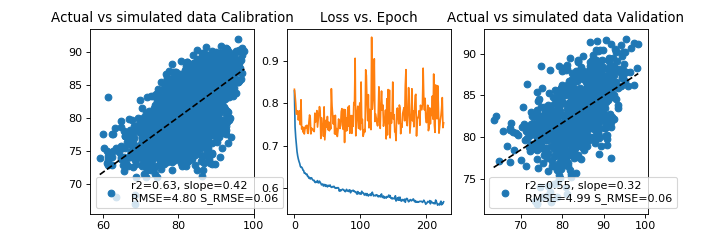

<IPython.core.display.Javascript object>


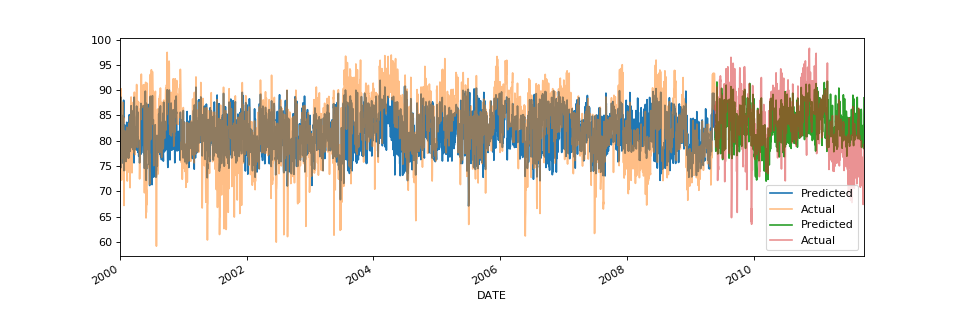

In [231]:
# run the training dataset back through the netowrk to show how well it can match its traing values over calibration data (comp vs obs)    # this is a first order 

#### All plots
fig2, ax = plt.subplots(1, 3, figsize=(9, 3))

######## plot 1 to 1 for # view results of predictions on the calibration data 
y_pred_calibration = model.predict(X_train)
y_pred_calibration = y_train_scaler.inverse_transform(y_pred_calibration)    # unscale the final data baed on the scaler from the initial scaling cell abovee

xcal = np.squeeze(train_data[y_col].values)
ycal = np.squeeze(y_pred_calibration)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xcal, ycal)                              # get stats on regression
mea = np.mean(np.abs(xcal-ycal))
rmse = np.sqrt(np.mean(np.abs(xcal-ycal)**2))                                     # couple more basic stats on the residuals, Mean absolute errir and root RMSE root mean squared error
Std_RMSE = rmse/((np.mean(xcal)+np.mean(ycal))/2)                                 # standardize the RMSE as a % of the mean
ax[0].plot(np.unique(xcal), np.poly1d(np.polyfit(xcal, ycal, 1))(np.unique(xcal)),  color = 'k', linestyle = "--")    # plot the linear regresion line 
ax[0].scatter(xcal, ycal, label="r2={0:1.2f}, slope={1:1.2f}\nRMSE={2:1.2f} S_RMSE={3:1.2f}".format(r_value, slope, rmse, Std_RMSE))   
ax[0].set_title('Actual vs simulated data Calibration')
ax[0].legend()

###### Plot losses
ax[1].set_title('Loss vs. Epoch')
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])

###### plot 1 to 1 for # view results of predictions on the validation data 
y_pred_validation = model.predict(X_val)
y_pred_validation = y_val_scaler.inverse_transform(y_pred_validation)    # unscale the final data baed on the scaler from the initial scaling cell abovee

xval = np.squeeze(val_data[y_col].values)
yval = np.squeeze(y_pred_validation)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xval, yval)                              # get stats on regression
mea = np.mean(np.abs(xval-yval))
rmse = np.sqrt(np.mean(np.abs(xval-yval)**2))                                     # couple more basic stats on the residuals, Mean absolute errir and root RMSE root mean squared error
Std_RMSE = rmse/((np.mean(xval)+np.mean(yval))/2)                                 # standardize the RMSE as a % of the mean
ax[2].plot(np.unique(xval), np.poly1d(np.polyfit(xval, yval, 1))(np.unique(xval)),  color = 'k', linestyle = "--")    # plot the linear regresion line 
ax[2].scatter(xval, yval, label="r2={0:1.2f}, slope={1:1.2f}\nRMSE={2:1.2f} S_RMSE={3:1.2f}".format(r_value, slope, rmse, Std_RMSE))   
ax[2].set_title('Actual vs simulated data Validation')
ax[2].legend()

##### time series plot
plt.figure(figsize=(12, 4))
plt.plot(train_data.index, ycal, label='Predicted')
train_data[y_col].plot(label='Actual', alpha = .5)
plt.plot(val_data.index, yval, label='Predicted')
val_data[y_col].plot(label='Actual', alpha = .5)
plt.legend(loc='best')

### Compare to simply gap filling with the mean

<IPython.core.display.Javascript object>


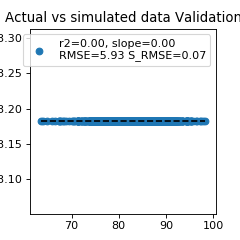

<IPython.core.display.Javascript object>


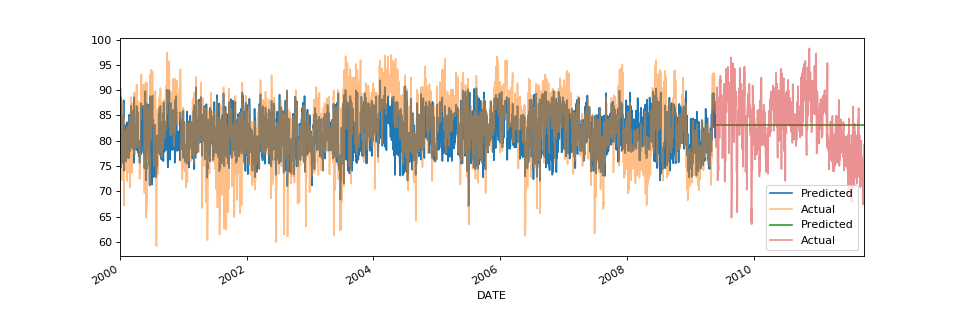

In [232]:
# run the training dataset back through the netowrk to show how well it can match its traing values over calibration data (comp vs obs)    # this is a first order 

#### All plots
fig2, ax = plt.subplots(1, 1, figsize=(3, 3))

###### plot 1 to 1 for # view results of predictions on the validation data 
y_pred_validation = np.full(np.shape(y_val), y_val.mean())
y_pred_validation = y_val_scaler.inverse_transform(y_pred_validation)    # unscale the final data baed on the scaler from the initial scaling cell abovee

xval = np.squeeze(val_data[y_col].values)
yval = np.squeeze(y_pred_validation)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xval, yval)                              # get stats on regression
mea = np.mean(np.abs(xval-yval))
rmse = np.sqrt(np.mean(np.abs(xval-yval)**2))                                     # couple more basic stats on the residuals, Mean absolute errir and root RMSE root mean squared error
Std_RMSE = rmse/((np.mean(xval)+np.mean(yval))/2)                                 # standardize the RMSE as a % of the mean
ax.plot(np.unique(xval), np.poly1d(np.polyfit(xval, yval, 1))(np.unique(xval)),  color = 'k', linestyle = "--")    # plot the linear regresion line 
ax.scatter(xval, yval, label="r2={0:1.2f}, slope={1:1.2f}\nRMSE={2:1.2f} S_RMSE={3:1.2f}".format(r_value, slope, rmse, Std_RMSE))   
ax.set_title('Actual vs simulated data Validation')
ax.legend()

##### time series plot
plt.figure(figsize=(12, 4))
plt.plot(train_data.index, ycal, label='Predicted')
train_data[y_col].plot(label='Actual', alpha = .5)
plt.plot(val_data.index, yval, label='Predicted')
val_data[y_col].plot(label='Actual', alpha = .5)
plt.legend(loc='best')

# Use the model, fill the gaps 
even though the model is un-ideal at the moment....
On issue to fix someday is that the absolute magnitudes of the data don't get quite up to par (the slope is under predicted...)

In [233]:
# Set up the gap filling by definging datasets and IDing the series needeing filling.

magic_data = dataset_cleanish.copy()
all_cols = list(magic_data.columns)
train_data_all = unbroken_data

# this bit makes a list of the variable that need some filling. (1 or > gaps) 
broken_vars = []
for var in all_cols:
    wha = find_date_gaps(dataset_cleanish, var)
    
    if wha[0]:                   # this means if the gap start lists are not empty
        broken_vars.append(var)  # make the list of broken variables

gap 0 is 427 days 00:00:00 from 2011-10-01 00:00:00 to 2012-12-01 00:00:00
gap 0 is 365 days 00:00:00 from 2015-01-01 00:00:00 to 2016-01-01 00:00:00


### Monster loop to fill all the gaps!

note this doesn't work if there are overlapping gaps ( to get around an overlappig 5 day gap I had to extend the mean fill period to 7 days, not the best...


Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_328 (Dense)            (None, 12)                60        
_________________________________________________________________
dense_329 (Dense)            (None, 80)                1040      
_________________________________________________________________
dense_330 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_331 (Dense)            (None, 1)                 81        
Total params: 7,661
Trainable params: 7,661
Non-trainable params: 0
_________________________________________________________________
4291/4291 [==============================] - 1s 219us/step
Score: loss of 0.6424184772718817; acc of 0.0%
gap 0 is 427 days 00:00:00 from 2011-10-01 00:00:00 to 2012-12-01 00:00:00
Model: "sequential_77"
_____________________________________________

<IPython.core.display.Javascript object>


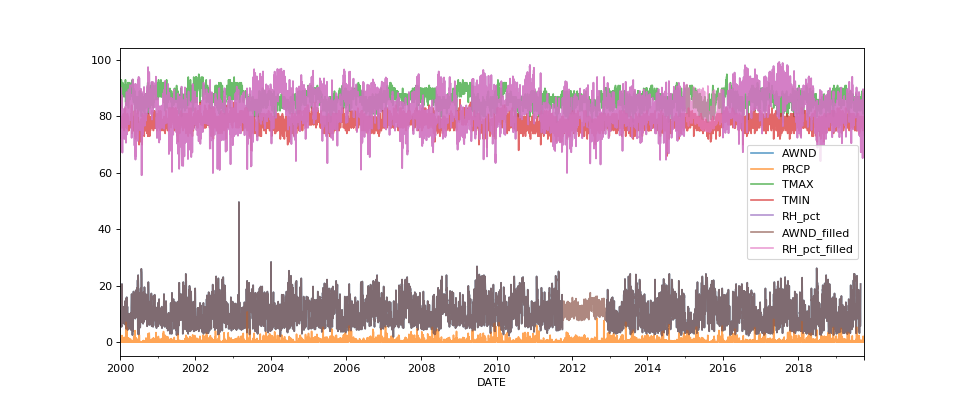

In [234]:
magic_data = dataset_cleanish.copy()
YScaler_dic = {}; XScaler_dic = {}

for i in broken_vars:
    x_cols = ['AWND', 'PRCP', 'TMAX', 'TMIN', 'RH_pct']
    x_cols.remove(i)                                     # remove the param of interest
    y_col = i

    # set up the training datasets
    X_train = train_data_all[x_cols].values  
    # scale the x component of the training data
    XScaler_dic[i] = StandardScaler().fit(X_train)
    X_train =  XScaler_dic[i].transform(X_train)
    y_train = train_data_all[y_col].values                 
    # scale the y data too, and then make the scale unique to use it to unscale the final data later
    y_train = y_train.reshape(-1, 1)
    YScaler_dic[i] = StandardScaler().fit(y_train)
    y_train = YScaler_dic[i].transform(y_train) 
    
# set up the DL network     
    model = "reset"; del model   # redefine, then delete model to make sure previous model weights are DESTROIED!
    model = define_model_dense(hidden_layer_sizes, input_shape, activation, optimizer)

    
# train the network
    # Note using callbacks from ( https://www.machinecurve.com/index.php/2019/05/30/avoid-wasting-resources-with-earlystopping-and-modelcheckpoint-in-keras/ )
    checkpoint_path = os.path.join(os.getcwd(), 'testmodel_random_callback_save.h5')
    keras_callbacks   = [EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.001),
                         ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')]

    history = model.fit(X_train, y_train, epochs=2000,verbose=0, validation_data =(X_val,  y_val), callbacks=keras_callbacks)

    # load the best saved model based on validation loss
    model = load_model(checkpoint_path)
    scores = model.evaluate(X_train, y_train, verbose=1)
    print(f'Score: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    
# fill the gaps 
    Strt_gp, End_gp = find_date_gaps(magic_data, i)                         # define all the existing gaps
    
    for idx, val in enumerate(Strt_gp):                                     # for each gap
        X_fill = magic_data[x_cols].loc[Strt_gp[idx]:End_gp[idx]].values    # existing data in other columns 
        # scale the x component of the fill data
        X_fill =  XScaler_dic[i].transform(X_fill)                           # scale existing data in other columns  
        y_pred_fill = model.predict(X_fill)                                 # use the network to generate predicted valued for desired column
        
        y_pred_fill = YScaler_dic[i].inverse_transform(y_pred_fill)    # unscale the final data baed on the scaler from the initial scaling cell above (have to use dictionary of scalers to make sure each col is scaled right)

        # replace the gap with predicted data!
        magic_data['{}_filled'.format(i)] = magic_data[i]
        magic_data['{}_filled'.format(i)].loc[Strt_gp[idx]:End_gp[idx]] = np.squeeze(y_pred_fill)       
        
magic_data.plot(figsize = (12, 5), alpha = .7)
magic_data.to_csv(os.path.join(workspace, "Magic_gap_filled_PPG_data.csv"))

# Now load in other datasets  from other weather stations

### Pull UH-ASPA data off of my GitHub site
note, reflects most recent update of processed data, not raw data

In [15]:
url = "https://raw.githubusercontent.com/cshuler/ASPA-UH_Integrated_Modeling_Framework/master/ASPA-UH_Wx_REPO/workspace/QA_All_merged.csv"
save_to = os.path.join("..", 'Data', "All_consolodated_Q_m3ps.csv")

r = requests.get(url, allow_redirects=True)
open(save_to, 'wb').write(r.content)

16346953

#### get the data into memory

<IPython.core.display.Javascript object>


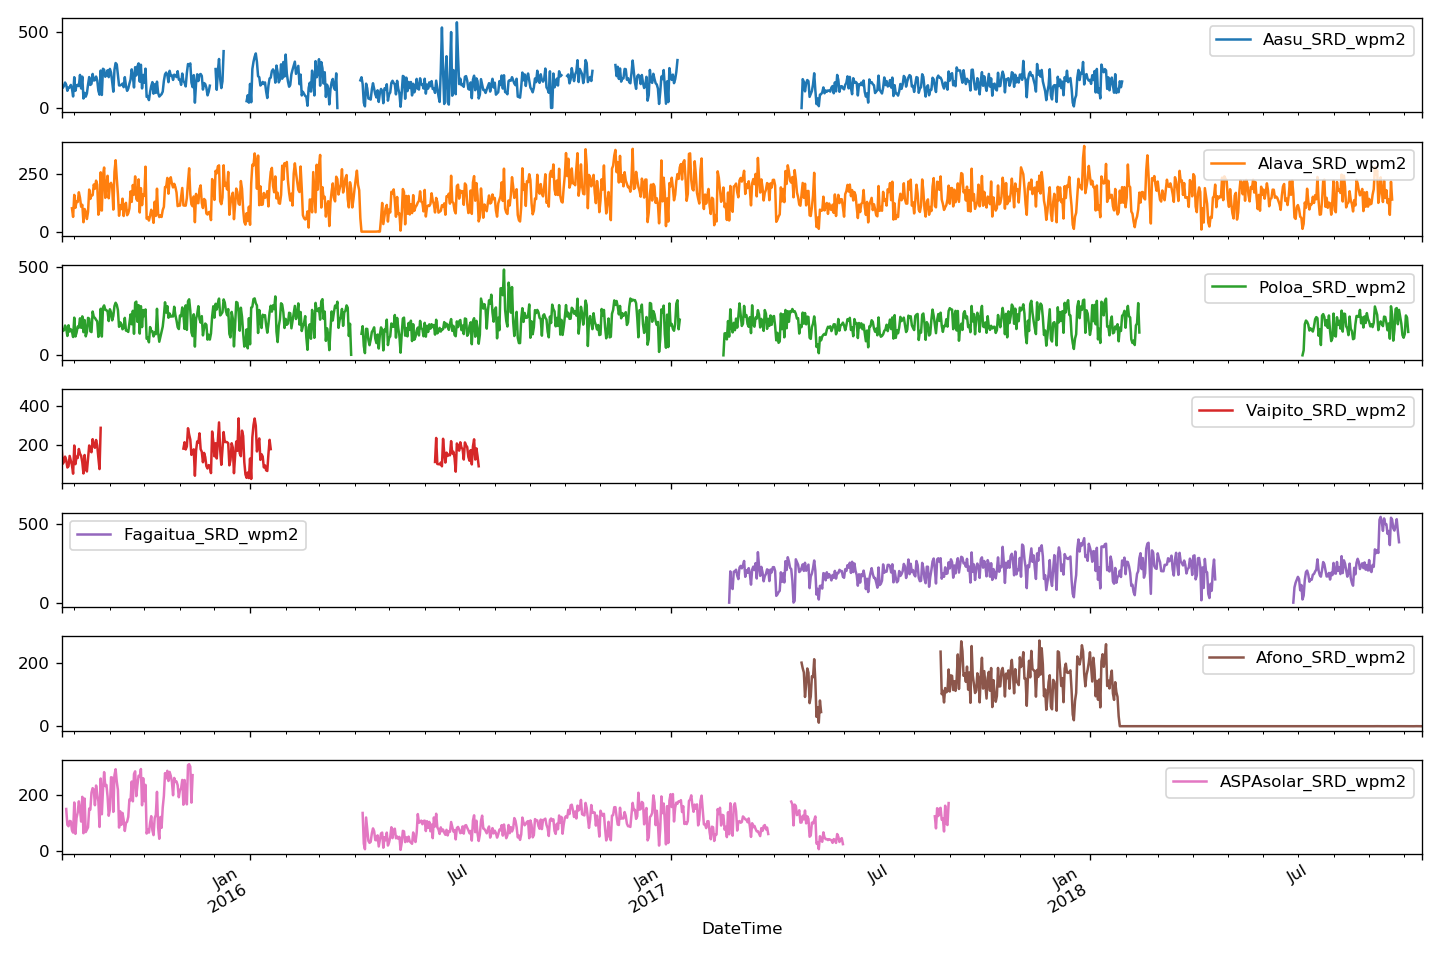

<IPython.core.display.Javascript object>


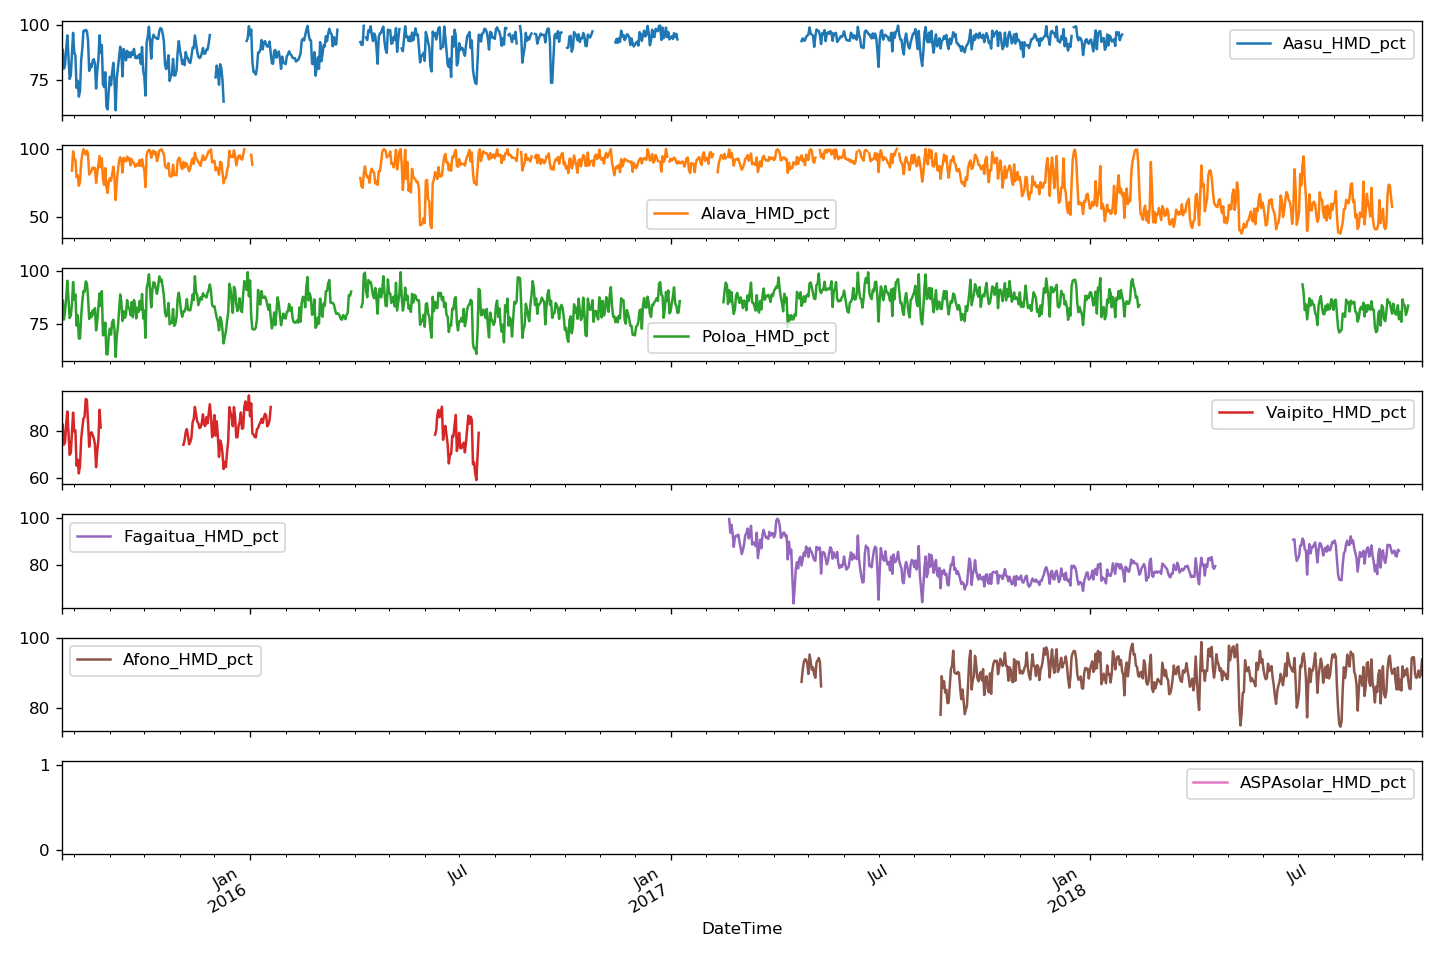

<IPython.core.display.Javascript object>


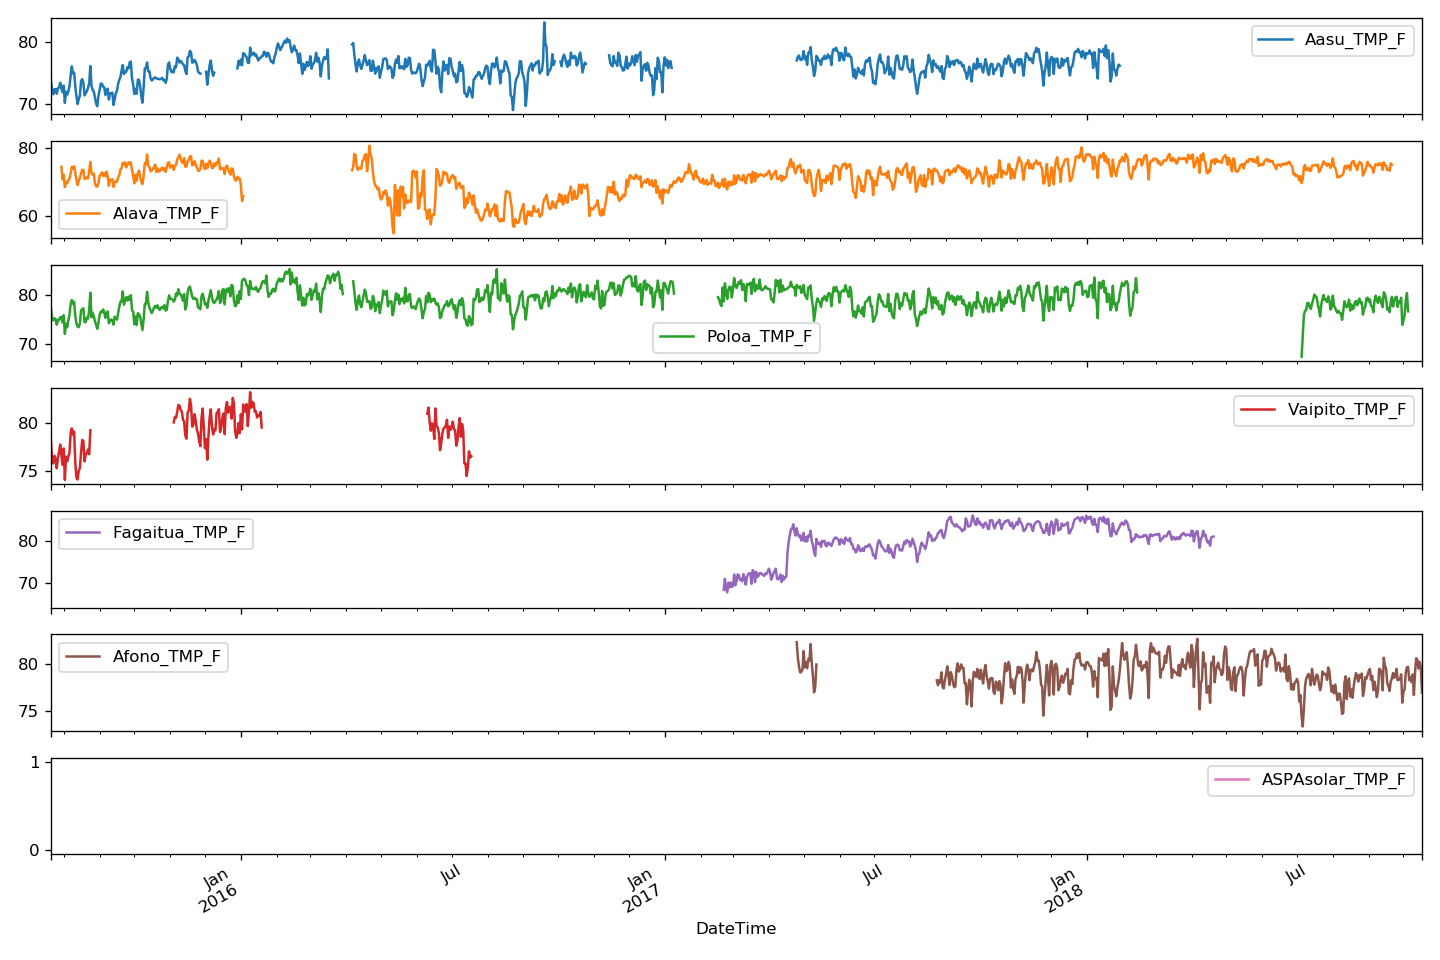

<IPython.core.display.Javascript object>


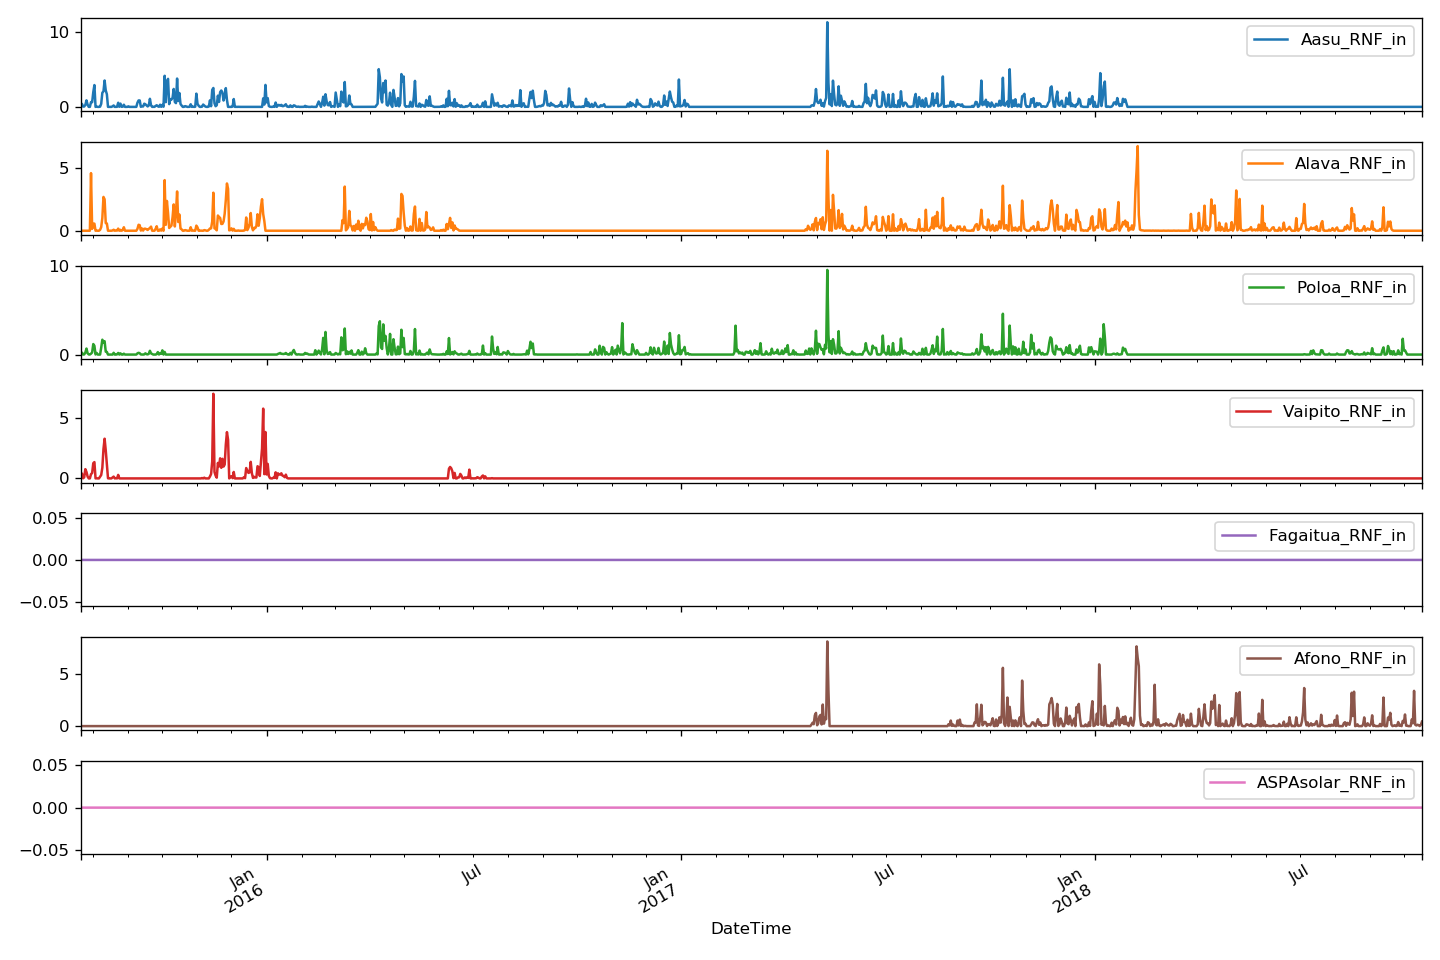

<IPython.core.display.Javascript object>


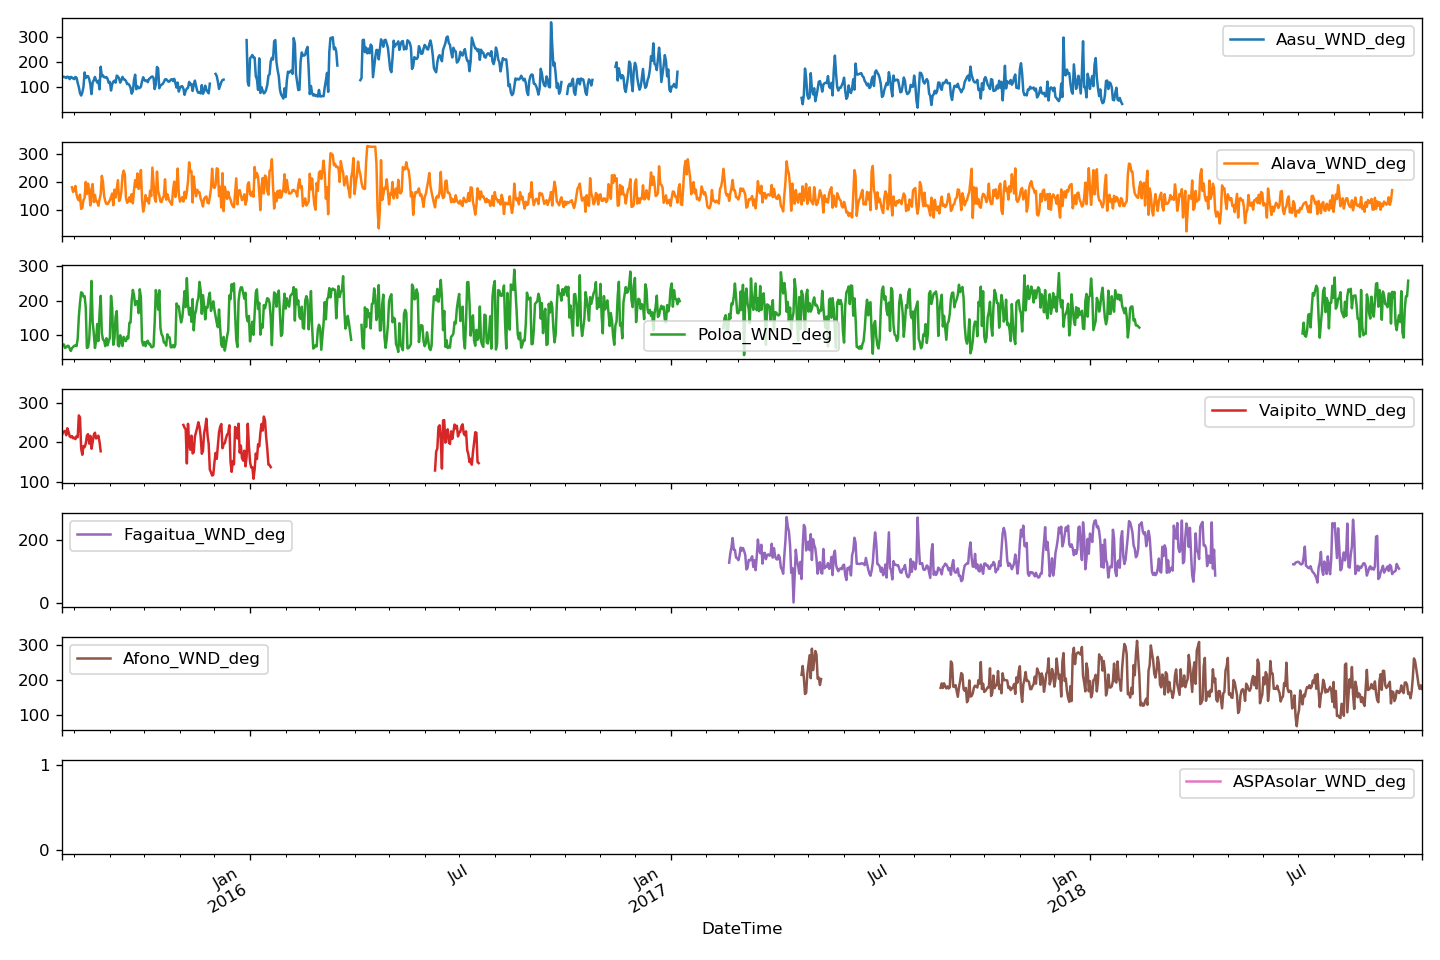

<IPython.core.display.Javascript object>


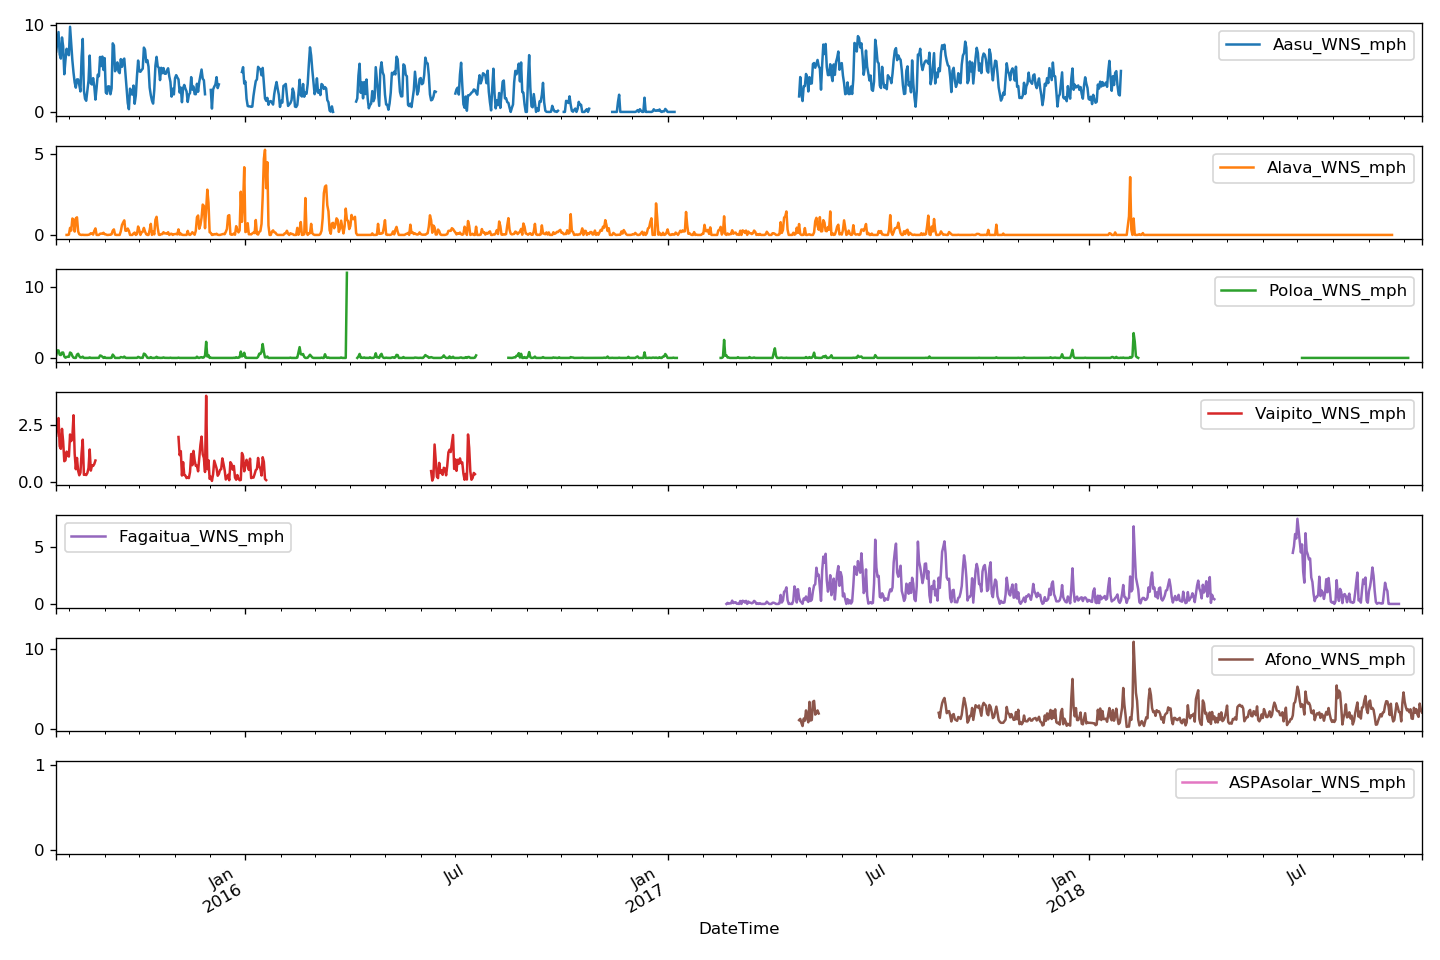

In [16]:
rawdata = pd.read_csv(save_to ,index_col=1,parse_dates=True)   # read in data
rawdata = rawdata.drop(rawdata.columns[0], axis=1)             # get rid of pesky index column

param_list =  ['SRD_wpm2', 'HMD_pct', 'TMP_F', 'RNF_in', 'WND_deg', 'WNS_mph']

ASPA_param_dic = {}
for q in param_list: 
    r = re.compile(".*{}".format(q))  
    Col_list = list(filter(r.match, list(rawdata.columns)))
    tempframe = rawdata[Col_list]
    ASPA_param_dic[q] = tempframe
    
# resample the rainfall to hourly values using a sum method
ASPA_param_dic['RNF_in'] = ASPA_param_dic['RNF_in'].resample('D').sum()     # subsample the 15 min data into daily values
# resample all others to hourly values using a average method
ave_param_list = ['SRD_wpm2', 'HMD_pct', 'TMP_F', 'WND_deg', 'WNS_mph'] 
for i in ave_param_list:
    ASPA_param_dic[i] = ASPA_param_dic[i].resample('D').mean()     # subsample the 15 min data into daily values

# Exoloratory Plot  All the datasets 
for i in param_list: 
    ASPA_param_dic[i].plot(subplots=True, figsize=(12, 8))
    plt.tight_layout()
    plt.legend(loc='best')  

# Tula Data
From Tula weather station, pre-downloaded and living in a file folder, Tula site is: https://www.esrl.noaa.gov/gmd/obop/smo/

### careful, long run time

In [449]:
# processing Tula data into a single dataframe
path_Tula_data = os.path.join("..", "Data", 'External_weather_data', 'Tula', "Met")

trash_cols = ['SITE CODE', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'WND', 'WNS_mpsec', 'WND_STEADY', 'BAR_p', 'TMP_2m', 'TMP_10m', 'TMP_top', 'HMD', 'PRECIP_mm']
want_cols = ['Date', 'PRECIP_mm', 'HMD', 'TMP_2m', 'WND', 'WNS_mpsec']

files = os.listdir(path_Tula_data)                     # get all file names in the folder
na_values = ['-99', '-9', '-999', '-99.9', '-999.9']   #values to turn into NaN 
temp_data =  pd.DataFrame(columns=trash_cols)          # empty container for concat

for i in files: 
    q = pd.read_csv(os.path.join(path_Tula_data, i), delim_whitespace=True, names=trash_cols, na_values=na_values) # open each file
    temp_data = pd.concat([temp_data, q], axis=0)     # stick em all together

temp_data['Date'] = temp_data[['YEAR', 'MONTH', 'DAY', 'HOUR']].apply(lambda x : datetime(*x),axis = 1)  # make the date a date
tula_data2 = temp_data[want_cols].set_index("Date") 

tula_data2['HMD'] = tula_data2['HMD'].apply(lambda x: 100 if x >99.9  else x) #Wtf?  Why are rel HMD values greater than 100%? fix this with some comon sense

# Now resampling data into neeed formats   this is set up for daily resampling 
tula_data2['Tmp_max'] = tula_data2['TMP_2m']                   # just make the columns get ready for resampling
tula_data2['Tmp_min'] = tula_data2['TMP_2m']                  # just make the columns get ready for resampling
tula_data2 = tula_data2.rename(columns={'TMP_2m': 'TMP_ave'})  # just make the columns get ready for resampling

tula_data_rn = tula_data2['PRECIP_mm'].resample('D').sum()      # resample the rain different than the other columns
tula_data_tmax = tula_data2['Tmp_max'].resample('D').max()      # resample the tmax different than the other columns
tula_data_tmin = tula_data2['Tmp_min'].resample('D').min()      # resample the tmin different than the other columns
tula_data_others = tula_data2[['HMD', 'TMP_ave', 'WND', 'WNS_mpsec']].resample('D').mean()   
Tula_data = tula_data_others.join(tula_data_rn)                 #merge tehm back together
Tula_data = Tula_data.join(tula_data_tmin)                 #merge tehm back together
Tula_data = Tula_data.join(tula_data_tmax)                 #merge tehm back together

# unit conversions
Tula_data['RNF_in'] =  Tula_data['PRECIP_mm'].apply(lambda x: x*0.0393701)     # convert rain in mm to rain in inches
Tula_data['TMP_ave_F'] =  Tula_data['TMP_ave'].apply(lambda x: x*1.8 + 32)     # convert rain in mm to rain in inches
Tula_data['TMP_max_F'] =  Tula_data['Tmp_max'].apply(lambda x: x*1.8 + 32)     # convert rain in mm to rain in inches
Tula_data['Tmp_min_F'] =  Tula_data['Tmp_min'].apply(lambda x: x*1.8 + 32)     # convert rain in mm to rain in inches
Tula_data['WNS_mph'] =  Tula_data['WNS_mpsec'].apply(lambda x: x*2.23694)     # convert rain in mm to rain in inches
del Tula_data['WNS_mpsec']; del Tula_data['TMP_ave']; del Tula_data['PRECIP_mm']; del Tula_data['Tmp_max']; del Tula_data['Tmp_min']

# this block is to deal with the separate solar radiation (SLR )files
Path_go_SLR = os.path.join("..", "Data", 'External_weather_data', 'Tula', 'Slr') 

trash_cols = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'MIN', 'DIRECT', 'DIFFUSE2', 'D_GLOBAL', 'D_IR', 'Zenith']
want_cols = ["Date", "DIRECT"]

SLR_files = os.listdir(Path_go_SLR)                     # get all file names in the folder
na_values = ['-99', '-9', '-999', '-99.9', '-999.9']   #values to turn into NaN 

temp_data =  pd.DataFrame(columns=trash_cols)          # empty container for concat
for i in SLR_files: 
    q = pd.read_csv(os.path.join(Path_go_SLR, i), delim_whitespace=True, skiprows= range(0,4), names=trash_cols,  na_values=na_values) # open each file     
    temp_data = pd.concat([temp_data, q], axis=0)     # stick em all together

temp_data['Date'] = temp_data[['YEAR', 'MONTH', 'DAY', 'HOUR', 'MIN']].apply(lambda x : datetime(*x),axis = 1)  # make the date a date
tula_SLR2 = temp_data[want_cols].set_index("Date") 
tula_data_SLR = tula_SLR2['DIRECT'].resample('D').mean()      # resample the rain different than the other columns

Tula_data = Tula_data.join(tula_data_SLR)        
Tula_data = Tula_data.rename(columns={'DIRECT': 'SLR_wpm2'})

# this block deals with the fup that the station was obviously down but recording 0s for some periods. 
en10 = int(len(Tula_data)/10)                      # make the acceptable window of days without rain at 10 days.
s = 0; e = 9
for i in range(0,len10):
    if Tula_data['RNF_in'].iloc[s:e].sum() == 0:   # if the drought is more than 10 days long the sensor was bad so change values to nan
        Tula_data['RNF_in'].iloc[s:e] = np.nan
    s+=10; e+=10

In [450]:
# clear up the columns temporarily while I dont care abot these columns 
del Tula_data['WND']
del Tula_data['SLR_wpm2']
del Tula_data['TMP_ave_F']

<IPython.core.display.Javascript object>


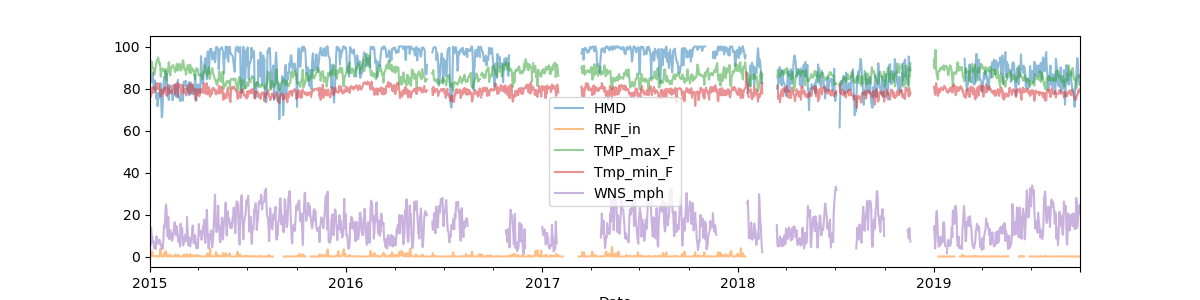

HMD    RNF_in  TMP_max_F  Tmp_min_F    WNS_mph
Date                                                             
2015-01-01   86.416667  0.944882      83.66      77.72  12.275208
2015-01-02   85.166667  0.118110      90.86      79.52   5.638953
2015-01-03   84.000000  0.157480      88.52      76.10  13.645334
2015-01-04   83.000000  0.039370      92.84      80.24   9.954383
2015-01-05   84.666667  2.401576      91.40      78.62   9.861177
2015-01-06   87.750000  0.905512      89.78      77.72   6.878590
2015-01-07   83.000000  0.157480      89.78      80.60   7.242093
2015-01-08   79.625000  0.157480      89.24      78.44   5.191565
2015-01-09   80.500000  0.236221      86.54      80.42   3.830760
2015-01-10   83.875000  0.078740      87.80      78.26   5.396618
2015-01-11   80.791667  0.236221      89.06      80.42   6.887911
2015-01-12   78.541667  0.236221      91.58      80.60   3.588425
2015-01-13   75.041667  0.078740      92.30      82.58   9.590880
2015-01-14   77.541667  0.039370      93.56      79.70   8.323281
2015-01-15   71.583333  0.000000      93.38      80.96   6.086341
2015-01-16   73.333333  0.000000      94.82      82.40   6.505767
2015-01-17   78.000000  0.275591      93.74      79.88   6.598973
2015-01-18   75.500000  0.000000      91.58      82.40   8.025022
2015-01-19   76.833333  0.236221      92.30      79.34   7.819969
2015-01-20   77.250000  3.622049      90.86      77.54   6.776064
2015-01-21   82.416667  2.755907      85.64      76.10   4.958550
2015-01-22   72.166667  0.000000      87.80      78.98   5.769441
2015-01-23   66.291667  0.000000      88.88      79.52   3.625707
2015-01-24   67.958333  0.000000      89.60      79.34   5.741479
2015-01-25   75.083333  0.078740      89.42      77.54   3.812119
2015-01-26   80.500000  0.433071      88.52      79.16   8.164831
2015-01-27   85.500000  1.456694      88.16      78.26  14.782445
2015-01-28   79.166667  0.000000      88.34      80.42  13.524166
2015-01-29   83.041667  0.787402      89.24      78.44  16.478791
2015-01-30   88.416667  2.519686      84.92      77.72  23.143008
2015-01-31   86.208333  0.629922      84.56      80.24  24.652943
2015-02-01   87.125000  1.259843      83.84      76.46  21.353456
2015-02-02   80.750000  0.000000      89.06      80.24  13.794463
2015-02-03   79.541667  0.236221      89.42      77.36   9.469713
2015-02-04   76.708333  0.000000      88.70      81.86  18.939425
2015-02-05   74.541667  0.000000      92.48      81.32  10.727991
2015-02-06   79.583333  0.748032      87.26      77.54   8.202113
2015-02-07   80.500000  0.984252      87.08      78.44  12.545505
2015-02-08   81.416667  0.118110      86.18      78.80  12.610749
2015-02-09   78.416667  0.000000      90.32      78.62   8.770669
2015-02-10   78.875000  0.433071      90.32      77.72  10.951685
2015-02-11   77.958333  0.196850      90.14      78.80   7.409864
2015-02-12   74.416667  0.000000      90.68      80.96   8.360563
2015-02-13   75.708333  0.000000      91.22      81.68   9.227378
2015-02-14   76.666667  0.078740      89.78      79.70  12.331132
2015-02-15   76.916667  0.078740      89.60      81.32  13.570769
2015-02-16   81.458333  0.669292      88.88      78.44  16.301700
2015-02-17   82.083333  0.826772      87.80      77.18  11.091494
2015-02-18   78.666667  0.000000      89.06      81.50  10.951685
2015-02-19   75.916667  0.000000      90.32      81.14   9.945062
2015-02-20   75.958333  0.000000      91.76      82.58  14.418942
2015-02-21   78.291667  0.000000      88.88      81.68  11.865103
2015-02-22   84.083333  0.944882      88.52      76.10  10.625465
2015-02-23   77.250000  0.000000      90.86      80.96   7.027720
2015-02-24   75.375000  0.078740      91.04      82.22   9.339225
2015-02-25   75.833333  0.000000      91.76      80.96   7.698802
2015-02-26   74.000000  0.118110      90.32      80.96   4.716215
2015-02-27   74.958333  0.000000      88.52      81.32  15.584015
2015-02-28   77.125000  0.039370      88.70      77.72   9.

In [451]:
Tula_data.plot(alpha=.5, figsize = (12,3))
Tula_data

# Processing historical ASCC data obtained from Mark

In [19]:
path_ASCC_data_old =  os.path.join("..", "Data", 'External_weather_data', 'ASCC', 'GroWeatherData 2004-2014.csv')
ASCC_All = pd.read_csv(os.path.join(path_ASCC_data_old), parse_dates=[['Date', 'Time']],  keep_date_col=True,  usecols = [0,1, 2, 8, 12, 14, 17, 19], na_values = ["--", "---"])

# clean data
ASCC_All['Date_Time'] = pd.to_datetime(ASCC_All['Date_Time'], errors='coerce')
del ASCC_All['Date']
del ASCC_All['Time']
numcols = ['Air Temp', 'Solar Rad', 'Wind Speed', 'Rain', 'Hum']
for i in numcols:
    ASCC_All[i] = pd.to_numeric(ASCC_All[i], errors='coerce')
ASCC_All = ASCC_All.set_index('Date_Time')

#resample daily 
ASCC_All['Tmp_max'] = ASCC_All['Air Temp']                   # just make the columns get ready for resampling
ASCC_All['Tmp_min'] = ASCC_All['Air Temp']                  # just make the columns get ready for resampling
ASCC_All = ASCC_All.rename(columns={'Air Temp': 'TMP_ave'})  # just make the columns get ready for resampling

ASCC_day_rain = ASCC_All['Rain'].resample('D').sum()     # sum the rainfall by days
ASCC_day_tmax = ASCC_All['Tmp_max'].resample('D').max()      # resample the tmax different than the other columns
ASCC_day_tmin = ASCC_All['Tmp_min'].resample('D').min()      # resample the tmin different than the other columns
ASCC_day_others = ASCC_All[['TMP_ave', 'Solar Rad', 'Wind Speed', 'Hum']].resample('D').mean()   
ASCC_All = ASCC_day_others.join(ASCC_day_rain)                 #merge tehm back together
ASCC_All = ASCC_All.join(ASCC_day_tmax)                 #merge tehm back together
ASCC_All_daily = ASCC_All.join(ASCC_day_tmin)                 #merge tehm back together


# remove trash
ASCC_All_daily[ASCC_All_daily < 0] = np.nan
ASCC_All_daily = ASCC_All_daily.loc[:"2013-12-31"]     # remove trashy data at the end of the stations life

# Convert units 
ASCC_All_daily['Rain'] = ASCC_All_daily['Rain']*0.0393701   # convert mm to in.
ASCC_All_daily['Wind Speed'] = ASCC_All_daily['Wind Speed']*0.621371    # convert km/hr to mi/hr
ASCC_All_daily['Tmp_min'] = ASCC_All_daily['Tmp_min']*(9/5)+32    # convert km/hr to mi/hr
ASCC_All_daily['Tmp_max'] = ASCC_All_daily['Tmp_max']*(9/5)+32    # convert km/hr to mi/hr
ASCC_All_daily['TMP_ave'] = ASCC_All_daily['TMP_ave']*(9/5)+32    # convert km/hr to mi/hr

# distinguish old stion from new 
ASCC_All_daily_old = ASCC_All_daily


############  New station   ##################
# read in data from the new weather station.
path_ASCC_data_new =  os.path.join("..", "Data", 'External_weather_data', 'ASCC', 'ASCCWeatherData_2015-2018_direct.csv')
ASCC_All = pd.read_csv(os.path.join(path_ASCC_data_new), parse_dates=[['Date', 'Time']],  keep_date_col=True,  usecols = [0,1, 2, 5, 7, 8, 17, 19], na_values = ["--", "---"])

# clean data
ASCC_All['Date_Time'] = pd.to_datetime(ASCC_All['Date_Time'], errors='coerce')
del ASCC_All['Date']
del ASCC_All['Time']
ASCC_All = ASCC_All.rename(columns={'OutTemp':'Air Temp', 'HumOut':'Hum', 'SpeedWind':'Wind Speed', 'Rad.Solar':'Solar Rad'})
for i in numcols:
    ASCC_All[i] = pd.to_numeric(ASCC_All[i], errors='coerce')
ASCC_All = ASCC_All.set_index('Date_Time')

#resample daily 

ASCC_All['Tmp_max'] = ASCC_All['Air Temp']                   # just make the columns get ready for resampling
ASCC_All['Tmp_min'] = ASCC_All['Air Temp']                  # just make the columns get ready for resampling
ASCC_All = ASCC_All.rename(columns={'Air Temp': 'TMP_ave'})  # just make the columns get ready for resampling


ASCC_day_rain = ASCC_All['Rain'].resample('D').sum()     # sum the rainfall by days
ASCC_day_tmax = ASCC_All['Tmp_max'].resample('D').max()      # resample the tmax different than the other columns
ASCC_day_tmin = ASCC_All['Tmp_min'].resample('D').min()      # resample the tmin different than the other columns
ASCC_day_others = ASCC_All[['TMP_ave', 'Solar Rad', 'Wind Speed', 'Hum']].resample('D').mean()   
ASCC_All = ASCC_day_others.join(ASCC_day_rain)                 #merge tehm back together
ASCC_All = ASCC_All.join(ASCC_day_tmax)                 #merge tehm back together
ASCC_All_daily = ASCC_All.join(ASCC_day_tmin)                 #merge tehm back together

# Convert units 
ASCC_All_daily['Rain'] = ASCC_All_daily['Rain']*0.0393701   # convert mm to in.
ASCC_All_daily['Wind Speed'] = ASCC_All_daily['Wind Speed']*0.621371    # convert km/hr to mi/hr
ASCC_All_daily['Tmp_min'] = ASCC_All_daily['Tmp_min']*(9/5)+32    # convert km/hr to mi/hr
ASCC_All_daily['Tmp_max'] = ASCC_All_daily['Tmp_max']*(9/5)+32    # convert km/hr to mi/hr
ASCC_All_daily['TMP_ave'] = ASCC_All_daily['TMP_ave']*(9/5)+32    # convert km/hr to mi/hr

# distinguish old stion from new 
ASCC_All_daily_new = ASCC_All_daily

# merge old and new
ASCC_All_combined = pd.concat([ASCC_All_daily_old, ASCC_All_daily_new])

<IPython.core.display.Javascript object>


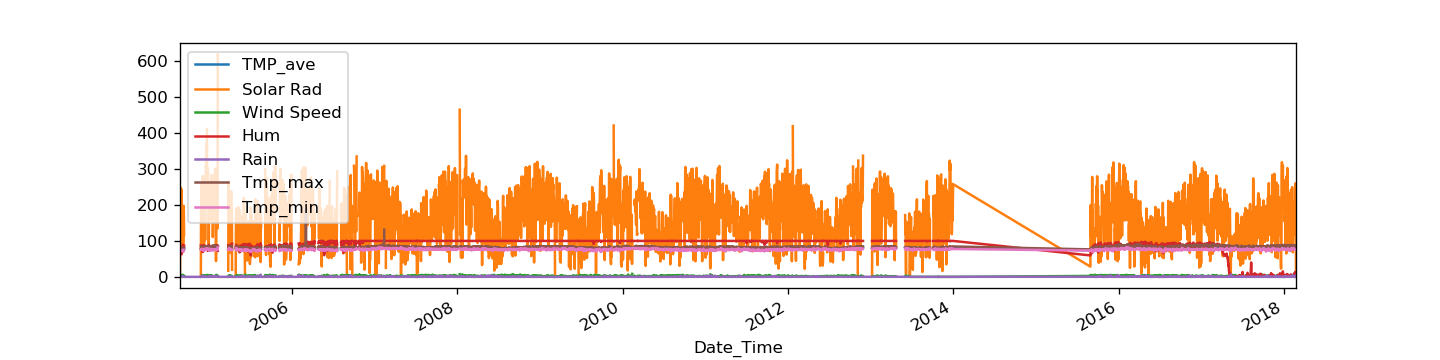

TMP_ave   Solar Rad  Wind Speed        Hum      Rain  Tmp_max  \
Date_Time                                                                     
2004-08-26  74.002609    0.000000    1.123871  91.739130  0.000000    74.12   
2004-08-27  77.961250  160.409722    3.194235  81.326389  0.031496    81.86   
2004-08-28  77.934581  248.798030    2.914322  76.980296  0.000000    82.22   
2004-08-29  77.476250  178.468750    2.312018  76.781250  0.000000    82.58   
2004-08-30  77.577500  196.354167    2.455063  82.052083  0.110236    83.84   
...               ...         ...         ...        ...       ...      ...   
2018-02-18  80.643125  210.093750    0.020712   7.916667  0.015748    86.90   
2018-02-19  80.650625  260.427083    0.020712  13.656250  0.015748    87.26   
2018-02-20  81.190625  181.708333    0.000000  12.208333  0.000000    87.44   
2018-02-21  80.157500  194.854167    2.447296   2.375000  0.062992    86.72   
2018-02-22  77.438261    7.579710    4.213616   1.000000  3.968506    81.86   

            Tmp_min  
Date_Time            
2004-08-26    73.94  
2004-08-27    73.76  
2004-08-28    74.12  
2004-08-29    73.04  
2004-08-30    73.40  
...             ...  
2018-02-18    76.46  
2018-02-19    76.10  
2018-02-20    76.28  
2018-02-21    75.92  
2018-02-22    75.38  

[4324 rows x 7 columns]

In [22]:
#fig, ax, = plt.subplots()
ASCC_All_combined.plot(figsize =(12,3))
ASCC_All_combined

# Start the big fill 

In [452]:
Tula_data.columns

Index(['HMD', 'RNF_in', 'TMP_max_F', 'Tmp_min_F', 'WNS_mph'], dtype='object')

working on filling HMD
Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_404 (Dense)            (None, 12)                24        
_________________________________________________________________
dense_405 (Dense)            (None, 80)                1040      
_________________________________________________________________
dense_406 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_407 (Dense)            (None, 1)                 81        
Total params: 7,625
Trainable params: 7,625
Non-trainable params: 0
_________________________________________________________________
Score: loss of 0.6861842812803535; acc of 0.0%


<IPython.core.display.Javascript object>


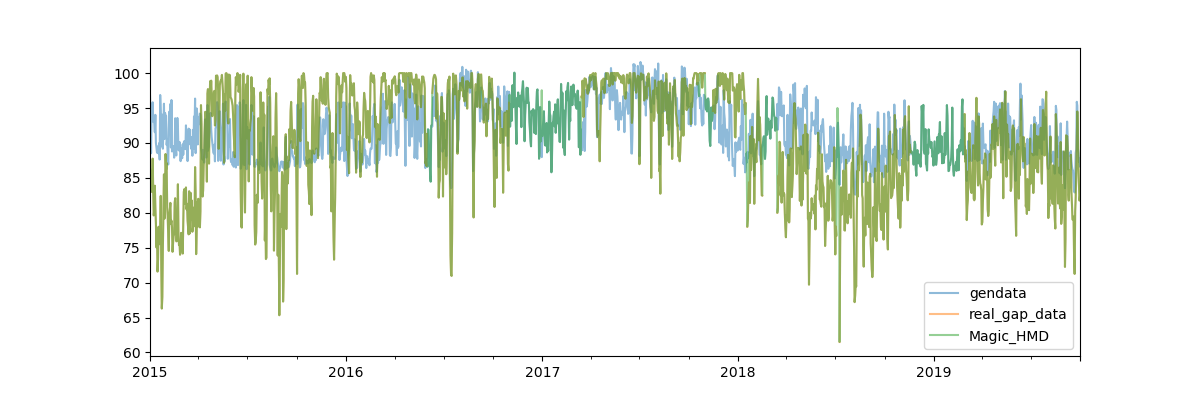

working on filling Tmp_min_F
Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_408 (Dense)            (None, 12)                24        
_________________________________________________________________
dense_409 (Dense)            (None, 80)                1040      
_________________________________________________________________
dense_410 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_411 (Dense)            (None, 1)                 81        
Total params: 7,625
Trainable params: 7,625
Non-trainable params: 0
_________________________________________________________________
Score: loss of 0.6662012703466237; acc of 0.0%


<IPython.core.display.Javascript object>


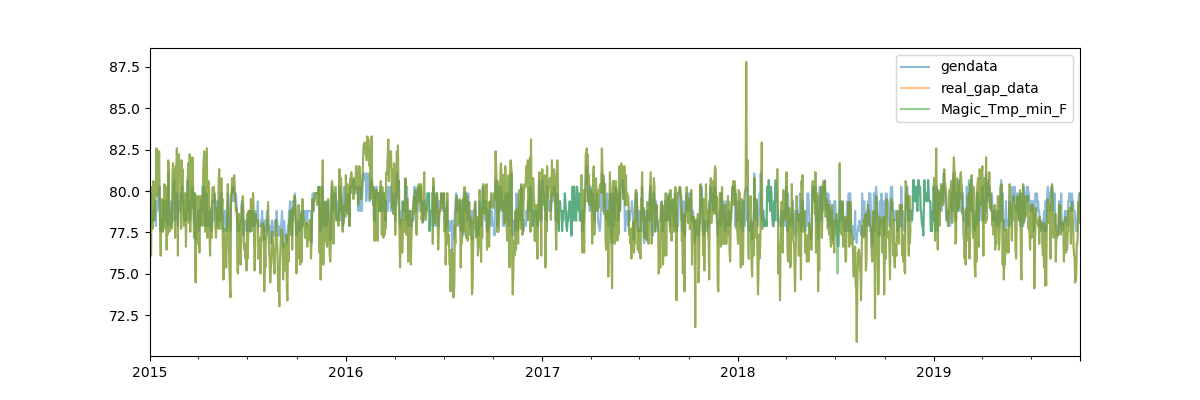

working on filling TMP_max_F
Model: "sequential_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_412 (Dense)            (None, 12)                24        
_________________________________________________________________
dense_413 (Dense)            (None, 80)                1040      
_________________________________________________________________
dense_414 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_415 (Dense)            (None, 1)                 81        
Total params: 7,625
Trainable params: 7,625
Non-trainable params: 0
_________________________________________________________________
Score: loss of 0.4999200415566731; acc of 0.0%


<IPython.core.display.Javascript object>


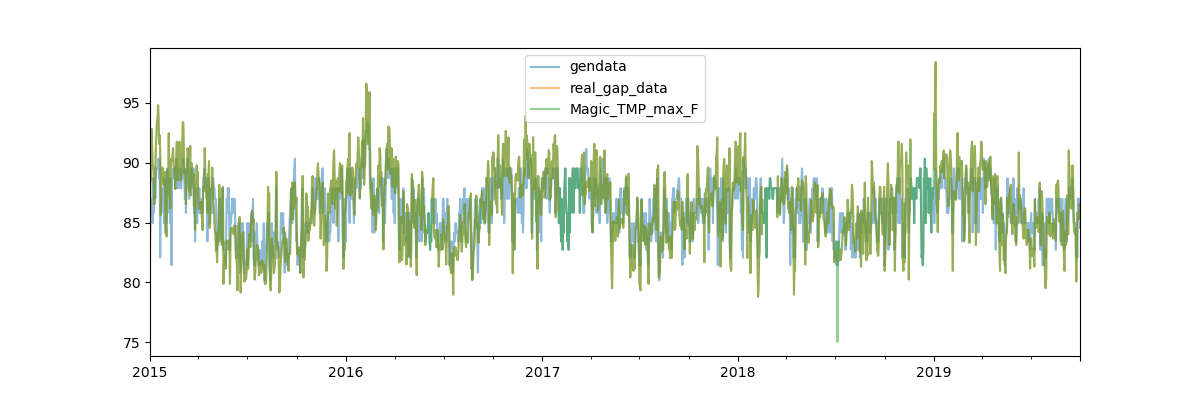

working on filling RNF_in
Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_416 (Dense)            (None, 12)                24        
_________________________________________________________________
dense_417 (Dense)            (None, 80)                1040      
_________________________________________________________________
dense_418 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_419 (Dense)            (None, 1)                 81        
Total params: 7,625
Trainable params: 7,625
Non-trainable params: 0
_________________________________________________________________
Score: loss of 0.8955134240966854; acc of 0.0%


<IPython.core.display.Javascript object>


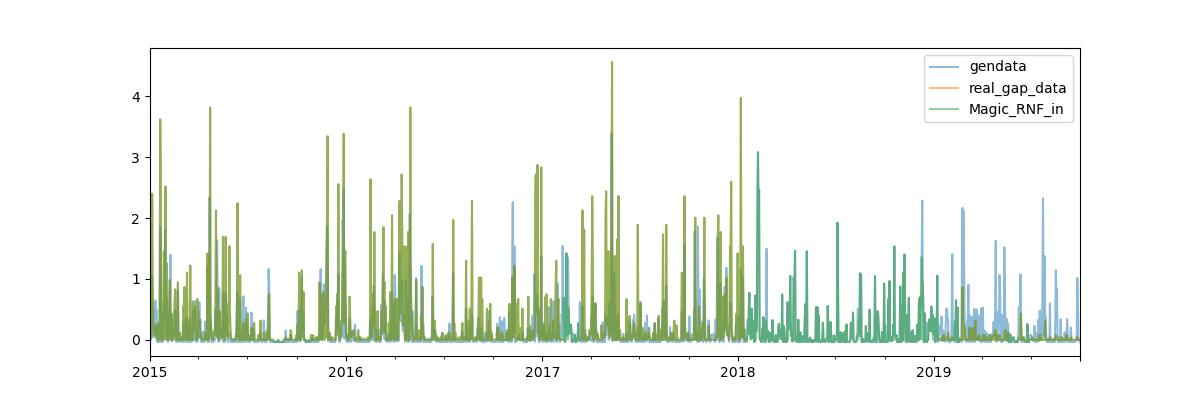

working on filling WNS_mph
Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_420 (Dense)            (None, 12)                24        
_________________________________________________________________
dense_421 (Dense)            (None, 80)                1040      
_________________________________________________________________
dense_422 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_423 (Dense)            (None, 1)                 81        
Total params: 7,625
Trainable params: 7,625
Non-trainable params: 0
_________________________________________________________________
Score: loss of 0.23458937669165747; acc of 0.0%


<IPython.core.display.Javascript object>


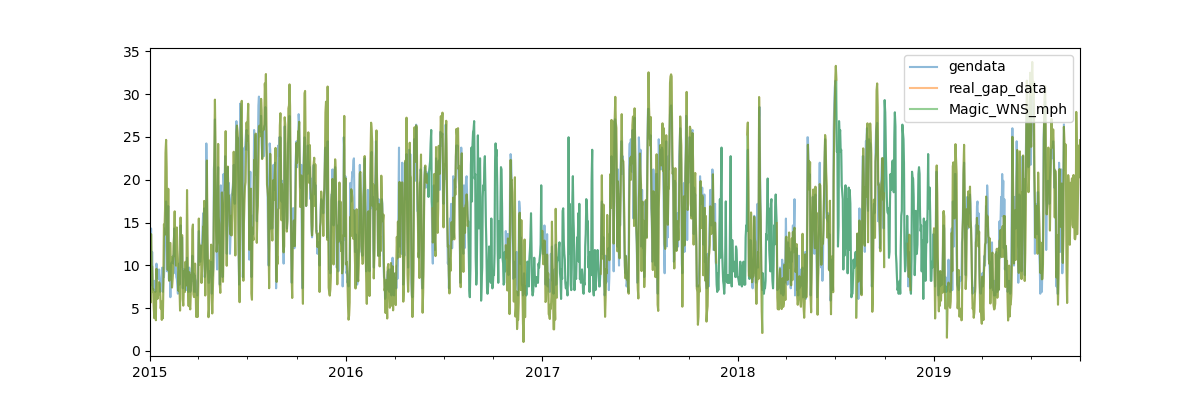

In [453]:
# fill in Tula dataset 
Magic_Tula_data = Tula_data.copy()   # the end result container

Tula_cols = ['HMD',           'Tmp_min_F', 'TMP_max_F', 'RNF_in', 'WNS_mph']
PPG_cols  = ['RH_pct_filled', 'TMIN',    'TMAX',    'PRCP',   'AWND_filled']

# model checkpoint params  
checkpoint_path = os.path.join(workspace, 'testmodel_random_callback_save2.h5')
keras_callbacks   = [EarlyStopping(monitor='val_loss', patience=15, mode='min', min_delta=0.01),
                     ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')]


for idx, tcol in enumerate(Tula_cols):
    print("working on filling {}".format(tcol))

    ppgcol = PPG_cols[idx]

    Tula_temp_frame = Tula_data[[tcol]]
    PPG_tempframe   = magic_data[[ppgcol]]

    # join the two colummns of same variable from different stations
    data = pd.merge(PPG_tempframe, Tula_temp_frame, how='inner', left_index=True, right_index=True)   # careful with the behavior of inner, seems to leave gaps with nan values but starts the frame where both datasets exist  which is what I want
    train_data = data.dropna()       # remove any rows where there is no data (a gap) 


    # define and scale each dataset
    X_train = train_data[ppgcol].values 
    X_train = X_train.reshape(-1, 1)
    X_train_scaler = StandardScaler().fit(X_train)
    X_train = X_train_scaler.transform(X_train)

    y_train = train_data[tcol].values                 # scale the y data too, and then make the scale unique to use it to unscale the final data later
    y_train = y_train.reshape(-1, 1)
    y_train_scaler = StandardScaler().fit(y_train)
    y_train = y_train_scaler.transform(y_train)

    #set up the network a-fresh
    model = "reset"; del model   # redefine, then delete model to make sure previous model weights are DESTROIED!
    model = define_model_dense(hidden_layer_sizes, 1, activation, optimizer)    # input shape of 1 since only training on one columns

    # train the network
    history = model.fit(X_train, y_train, epochs=2000,verbose=0, validation_split = .5, callbacks=keras_callbacks)

    ## load the best saved model based on validation loss
    model = load_model(checkpoint_path)
    scores = model.evaluate(X_train, y_train, verbose=0)
    print(f'Score: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')


    # now that we have the trained model, use it to predict parameter of interest. 
    X_fill = data[ppgcol].values 
    X_fill = X_fill.reshape(-1, 1)
    XScaler_dic[tcol] = StandardScaler().fit(X_fill)
    X_fill =  XScaler_dic[tcol].transform(X_fill)                       # scale existing data in other columns  
    y_pred_fill = model.predict(X_fill)                                 # use the network to generate predicted valued for desired column
    y_pred_fill = y_train_scaler.inverse_transform(y_pred_fill)         # rescale the data back to its real magnitudes

    generated_dataframe = pd.DataFrame(index = data.index, data = {"gendata":np.squeeze(y_pred_fill)})    
    generated_dataframe['real_gap_data'] = data[tcol]

    # if the real series has a gap fill with generated data, if not use real data
    generated_dataframe['Magic_{}'.format(tcol)] = generated_dataframe.apply(
        lambda row: row['gendata'] if np.isnan(row['real_gap_data']) else row['real_gap_data'], axis=1)   

    # merge it in to the big dataset
    Magic_Tula_data['Magic_{}'.format(tcol)] = generated_dataframe['Magic_{}'.format(tcol)]
    
    generated_dataframe.plot(figsize = (12,4), alpha=.5)

In [395]:
generated_dataframe = pd.DataFrame(index = data.index, data = {"gendata":np.squeeze(y_pred_fill)})    
generated_dataframe['real_gap_data'] = data[tcol]

# if the real series has a gap fill with generated data, if not use real data
generated_dataframe['Magic_{}'.format(tcol)] = generated_dataframe.apply(
    lambda row: row['gendata'] if np.isnan(row['real_gap_data']) else row['real_gap_data'], axis=1)   

# merge it in to the big dataset
Magic_Tula_data

<IPython.core.display.Javascript object>


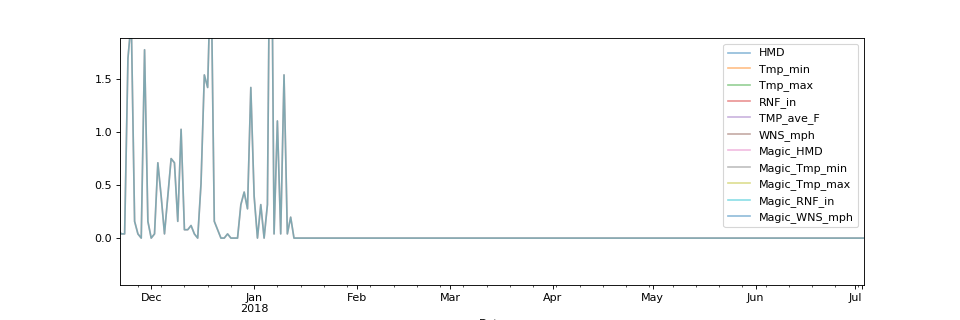

In [404]:
Magic_Tula_data.plot(figsize = (12,4), alpha =.5)



In [405]:
Tula_data

HMD         WND  Tmp_min  Tmp_max    RNF_in  TMP_ave_F  \
Date                                                                        
2015-01-01   86.416667  241.250000     25.4     28.7  0.944882  80.840000   
2015-01-02   85.166667  128.500000     26.4     32.7  0.118110  82.175000   
2015-01-03   84.000000  150.291667     24.5     31.4  0.157480  81.042500   
2015-01-04   83.000000  127.333333     26.8     33.8  0.039370  83.007500   
2015-01-05   84.666667   97.166667     25.9     33.0  2.401576  82.452500   
2015-01-06   87.750000  177.000000     25.4     32.1  0.905512  80.757500   
2015-01-07   83.000000  196.958333     27.0     32.1  0.157480  82.947500   
2015-01-08   79.625000  266.666667     25.8     31.8  0.157480  82.542500   
2015-01-09   80.500000  261.583333     26.9     30.3  0.236221  82.400000   
2015-01-10   83.875000  194.875000     25.7     31.0  0.078740  81.335000   
2015-01-11   80.791667  314.541667     26.9     31.7  0.236221  83.547500   
2015-01-12   78.541667  175.375000     27.0     33.1  0.236221  84.740000   
2015-01-13   75.041667  112.416667     28.1     33.5  0.078740  85.625000   
2015-01-14   77.541667   83.458333     26.5     34.2  0.039370  84.950000   
2015-01-15   71.583333  101.875000     27.2     34.1  0.000000  85.820000   
2015-01-16   73.333333  121.500000     28.0     34.9  0.000000  87.155000   
2015-01-17   78.000000  109.500000     26.6     34.3  0.275591  85.220000   
2015-01-18   75.500000  243.916667     28.0     33.1  0.000000  85.632500   
2015-01-19   76.833333  140.166667     26.3     33.5  0.236221  85.505000   
2015-01-20   77.250000  238.625000     25.3     32.7  3.622049  83.630000   
2015-01-21   82.416667  235.541667     24.5     29.8  2.755907  79.265000   
2015-01-22   72.166667  197.916667     26.1     31.0  0.000000  82.842500   
2015-01-23   66.291667  197.166667     26.4     31.6  0.000000  83.135000   
2015-01-24   67.958333  238.333333     26.3     32.0  0.000000  83.315000   
2015-01-25   75.083333  249.083333     25.3     31.9  0.078740  82.610000   
2015-01-26   80.500000  300.250000     26.2     31.4  0.433071  83.000000   
2015-01-27   85.500000  301.666667     25.7     31.2  1.456694  80.870000   
2015-01-28   79.166667  286.041667     26.9     31.3  0.000000  82.767500   
2015-01-29   83.041667  231.416667     25.8     31.8  0.787402  81.927500   
2015-01-30   88.416667  296.041667     25.4     29.4  2.519686  79.865000   
2015-01-31   86.208333  321.416667     26.8     29.2  0.629922  81.305000   
2015-02-01   87.125000  228.833333     24.7     28.8  1.259843  79.587500   
2015-02-02   80.750000  176.250000     26.8     31.7  0.000000  82.775000   
2015-02-03   79.541667  155.791667     25.2     31.9  0.236221  82.617500   
2015-02-04   76.708333  126.166667     27.7     31.5  0.000000  84.290000   
2015-02-05   74.541667  127.666667     27.4     33.6  0.000000  84.800000   
2015-02-06   79.583333  301.375000     25.3     30.7  0.748032  82.595000   
2015-02-07   80.500000  317.208333     25.8     30.6  0.984252  82.227500   
2015-02-08   81.416667  279.791667     26.0     30.1  0.118110  81.972500   
2015-02-09   78.416667  195.375000     25.9     32.4  0.000000  82.280000   
2015-02-10   78.875000   83.500000     25.4     32.4  0.433071  82.902500   
2015-02-11   77.958333   91.583333     26.0     32.3  0.196850  83.165000   
2015-02-12   74.416667  130.833333     27.2     32.6  0.000000  84.425000   
2015-02-13   75.708333  114.000000     27.6     32.9  0.000000  84.920000   
2015-02-14   76.666667   86.833333     26.5     32.1  0.078740  84.597500   
2015-02-15   76.916667  119.583333     27.4     32.0  0.078740  83.877500   
2015-02-16   81.458333   99.916667     25.8     31.6  0.669292  82.572500   
2015-02-17   82.083333   80.625000     25.1     31.0  0.826772  82.235000   
2015-02-18   78.666667  104.833333     27.5     31.7  0.000000  83.690000   
2015-02-19   75.916667  192.833333     27.3     32.4  0.000000  84.852500   
2015-02-20   75

<IPython.core.display.Javascript object>


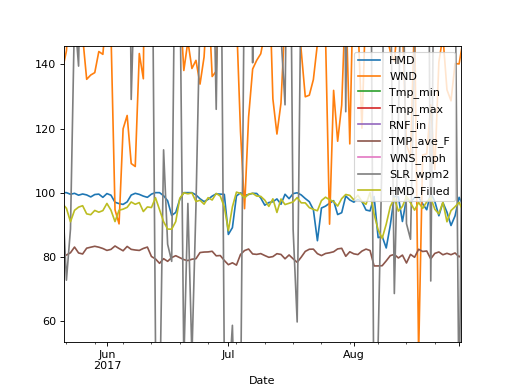

In [369]:
generated_dataframe = pd.DataFrame(index = data.index, data = {"gendata":np.squeeze(y_pred_fill)})    
generated_dataframe['real_gap_data'] = data[tcol]

# if the real series has a gap fill with generated data, if not use real data
generated_dataframe['Magic_{}'.format(tcol)] = generated_dataframe.apply(
    lambda row: row['gendata'] if np.isnan(row['real_gap_data']) else row['real_gap_data'], axis=1)   

# merge it in to the big dataset
Magic_Tula_data['Magic_{}'.format(tcol)] = generated_dataframe['Magic_{}'.format(tcol)]

<IPython.core.display.Javascript object>


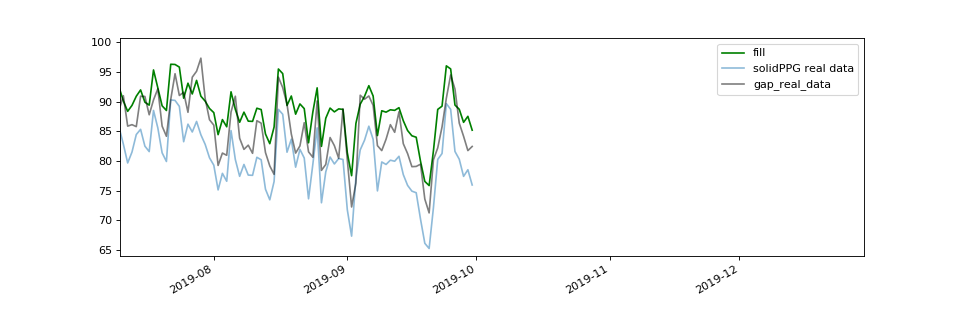

In [357]:
##### time series plot
plt.figure(figsize=(12, 4))
plt.plot(data.index, y_pred_fill, label='fill',  color = 'g')
data['RH_pct_filled'].plot(label='solidPPG real data', alpha = .5)
data['HMD'].plot(label='gap_real_data', alpha = .5, color = 'k')

#train_data[y_col].plot(label='Actual', alpha = .5)
#plt.plot(val_data.index, yval, label='Predicted')
#val_data[y_col].plot(label='Actual', alpha = .5)
plt.legend(loc='best')

<IPython.core.display.Javascript object>


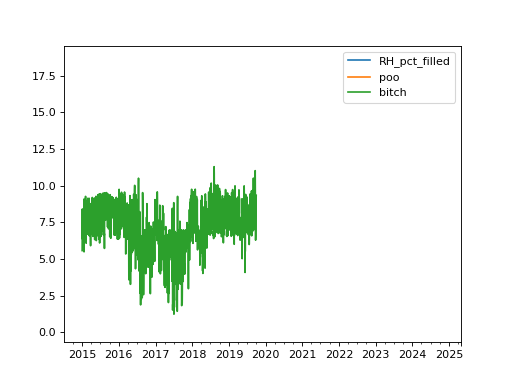

In [328]:
tempo = pd.DataFrame(index = data.index, data = {"poo":np.squeeze(y_pred_fill)})

fuckface = pd.merge(data[['RH_pct_filled']], tempo, how='inner', left_index=True, right_index=True)   
fuckface['bitch'] = fuckface['poo']-fuckface['RH_pct_filled']

fuckface.plot()